We explore other ways besides the schedule workloes to trigger workflows. Trigger actions are often the result of external events;
think of a file being uploaded to a shared drive, a developer pushing their code to
a repository, or the existence of a partition in a Hive table, any of which could be a
reason to start running your workflow.

####  Sensors
Sensors continuously poll for certain conditions to be true and succeed if so. If false, the sensor will wait and try again until either the condition is true or a timeout is eventually reached.

In [ ]:
from airflow.sensors.filesystem import FileSensor

wait_for_supermarket_1 = FileSensor(
    task_id="wait_for_supermarket_1",
    filepath="/data/supermarket1/data.csv",
)

#### PythonSensor
Similar to PythonOperator, in the sense of the need of a Python callable to execute. However, it is limited to only return True or False

In [ ]:
from pathlib import Path
from airflow.sensors.python import PythonSensor

def _wait_for_supermarket(supermarket_id):
    supermarket_path = Path("/data/" + supermarket_id)
    data_files = supermarket_path.glob("data-*.csv")
    success_file = supermarket_path / "_SUCCESS"
    return data_files and success_file.exists()

wait_for_supermarket_1 = PythonSensor(
    task_id="wait_for_supermarket_1",
    python_callable=_wait_for_supermarket,
    op_kwargs={"supermarket_id": "supermarket1"},
    dag=dag,
)

#### sensor deadlock
happens when number of sensors running outnumbers the DAG concurrency (max amount of tasks runnings at the same time). Sensors timeout by default is seven days, so we have to keep an eye on its timeout.

Note: Airflow also has a global limit of maximum tasks to be ran.

### Triggering other DAGs

We can make use of the <b>TriggerDagRunOperator</b>

In [ ]:
import airflow.utils.dates
from airflow import DAG
from airflow.operators.dummy import DummyOperator
from airflow.operators.trigger_dagrun import TriggerDagRunOperator

dag1 = DAG(
    dag_id="ingest_supermarket_data",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval="0 16 * * *",
)

for supermarket_id in range(1, 5):
# ...
    trigger_create_metrics_dag = TriggerDagRunOperator(
        task_id=f"trigger_create_metrics_dag_supermarket_{supermarket_id}",
        trigger_dag_id="create_metrics", ## Must match the desired dag_id
        dag=dag1,
)
    
dag2 = DAG(
    dag_id="create_metrics",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval=None, ## No schedule_interval required if only triggered
)
# ...

#### ExternalTaskOperator
What if multiple triggering DAGs must complete before another DAG can start running?
<div>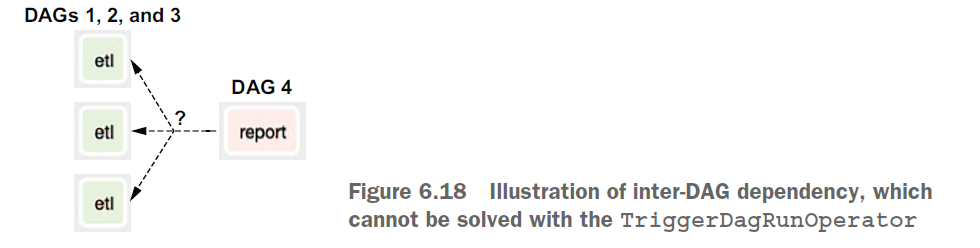</div>
<div>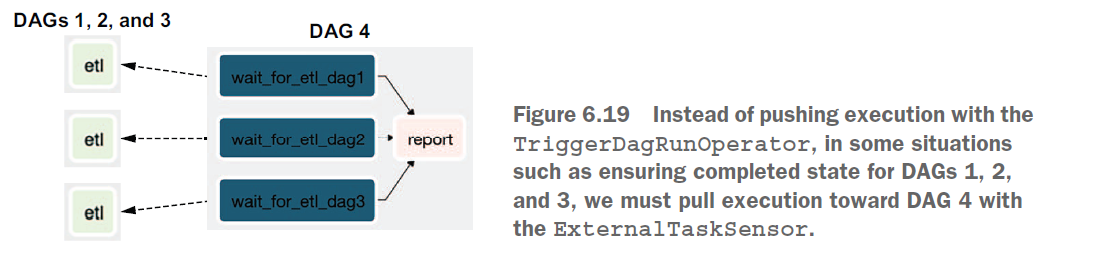</div>


In [ ]:
import airflow.utils.dates
from airflow import DAG
from airflow.operators.dummy import DummyOperator
from airflow.sensors.external_task import ExternalTaskSensor

dag1 = DAG(dag_id="ingest_supermarket_data", schedule_interval="0 16 * * *", ...)
dag2 = DAG(schedule_interval="0 16 * * *", ...)

DummyOperator(task_id="copy_to_raw", dag=dag1) >> DummyOperator(task_id="process_supermarket", dag=dag1)

wait = ExternalTaskSensor(
    task_id="wait_for_process_supermarket",
    external_dag_id="ingest_supermarket_data",
    external_task_id="process_supermarket",
dag=dag2,
)

report = DummyOperator(task_id="report", dag=dag2)
wait >> report

### Starting workflows via REST/CLI

In [ ]:
airflow dags trigger dag1